In [122]:
import numpy as np
import random
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual

import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold, validation_curve
from sklearn import metrics
from timeit import default_timer as timer
from sklearn import datasets, linear_model


In [123]:
games = pd.read_csv('games.csv')
ranking = pd.read_csv('ranking.csv')
teams = pd.read_csv('teams.csv')

In [124]:
# Length of NBA games dataset
print(len(games))

24195


# Data Collection and Data Cleaning

In [125]:
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2021-03-21  22000645            Final    1610612748       1610612754   
1    2021-03-21  22000016            Final    1610612745       1610612760   
2    2021-03-21  22000646            Final    1610612743       1610612740   
3    2021-03-21  22000167            Final    1610612738       1610612753   
4    2021-03-21  22000647            Final    1610612751       1610612764   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2020    1610612748     106.0        0.402        0.826  ...      27.0   
1    2020    1610612745     112.0        0.494        0.741  ...      22.0   
2    2020    1610612743     108.0        0.500        0.800  ...      30.0   
3    2020    1610612738     112.0        0.455        1.000  ...      27.0   
4    2020    1610612751     113.0        0.489        0.727  ...      24.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
0      51.0    1610612754     109.0        0.388        0.900         0.333   
1      38.0    1610612760     114.0        0.462        0.680         0.333   
2      37.0    1610612740     113.0        0.482        0.767         0.286   
3      45.0    1610612753      96.0        0.381        0.700         0.324   
4      35.0    1610612764     106.0        0.532        0.789         0.333   

   AST_away  REB_away  HOME_TEAM_WINS  
0      27.0      50.0               0  
1      22.0      52.0               0  
2      26.0      45.0               0  
3      20.0      44.0               1  
4      24.0      43.0               1  

[5 rows x 21 columns]

In [126]:
teams.head()

LEAGUE_ID     TEAM_ID  MIN_YEAR  MAX_YEAR ABBREVIATION   NICKNAME  \
0          0  1610612737      1949      2019          ATL      Hawks   
1          0  1610612738      1946      2019          BOS    Celtics   
2          0  1610612740      2002      2019          NOP   Pelicans   
3          0  1610612741      1966      2019          CHI      Bulls   
4          0  1610612742      1980      2019          DAL  Mavericks   

   YEARFOUNDED         CITY                     ARENA  ARENACAPACITY  \
0         1949      Atlanta          State Farm Arena        18729.0   
1         1946       Boston                 TD Garden        18624.0   
2         2002  New Orleans      Smoothie King Center            NaN   
3         1966      Chicago             United Center        21711.0   
4         1980       Dallas  American Airlines Center        19200.0   

             OWNER  GENERALMANAGER      HEADCOACH DLEAGUEAFFILIATION  
0     Tony Ressler  Travis Schlenk   Lloyd Pierce      Erie Bayhawks  
1    Wyc Grousbeck     Danny Ainge   Brad Stevens    Maine Red Claws  
2       Tom Benson  Trajan Langdon   Alvin Gentry       No Affiliate  
3  Jerry Reinsdorf      Gar Forman     Jim Boylen   Windy City Bulls  
4       Mark Cuban   Donnie Nelson  Rick Carlisle      Texas Legends

In [127]:
ranking.head()

TEAM_ID  LEAGUE_ID  SEASON_ID STANDINGSDATE CONFERENCE         TEAM   G  \
0  1610612762          0      22020    2021-03-21       West         Utah  41   
1  1610612756          0      22020    2021-03-21       West      Phoenix  41   
2  1610612747          0      22020    2021-03-21       West  L.A. Lakers  43   
3  1610612746          0      22020    2021-03-21       West  LA Clippers  43   
4  1610612743          0      22020    2021-03-21       West       Denver  42   

    W   L  W_PCT HOME_RECORD ROAD_RECORD  RETURNTOPLAY  
0  30  11  0.732        16-2        14-9           NaN  
1  28  13  0.683        15-8        13-5           NaN  
2  28  15  0.651        14-9        14-6           NaN  
3  27  16  0.628        14-6       13-10           NaN  
4  25  17  0.595        12-9        13-8           NaN

In [128]:
games['home_team_abv'] = games.HOME_TEAM_ID.map(teams.set_index('TEAM_ID')['ABBREVIATION'].to_dict())
games['home_team_nick'] = games.HOME_TEAM_ID.map(teams.set_index('TEAM_ID')['NICKNAME'].to_dict())

In [129]:
games['vis_team_abv'] = games.VISITOR_TEAM_ID.map(teams.set_index('TEAM_ID')['ABBREVIATION'].to_dict())
games['vis_team_nick'] = games.VISITOR_TEAM_ID.map(teams.set_index('TEAM_ID')['NICKNAME'].to_dict())

In [130]:
games['home_w_pct'] = games.HOME_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

In [131]:
games['vis_w_pct'] = games.VISITOR_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

In [132]:
games = games.iloc[::-1].reset_index(drop=True) # Reverse dataframe from oldest to most recent
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2014-10-04  11400001            Final    1610612748       1610612740   
1    2014-10-05  11400002            Final    1610612761       1610612758   
2    2014-10-06  11400005            Final    1610612747       1610612743   
3    2014-10-06  11400004            Final    1610612741       1610612764   
4    2014-10-06  11400007            Final    1610612737       1610612740   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
0    2014    1610612748      86.0        0.431        0.679  ...   
1    2014    1610612761      99.0        0.440        0.771  ...   
2    2014    1610612747      98.0        0.448        0.682  ...   
3    2014    1610612741      81.0        0.338        0.719  ...   
4    2014    1610612737      93.0        0.419        0.821  ...   

   FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  home_team_abv  \
0         0.438      19.0      42.0               0            MIA   
1         0.385      18.0      45.0               1            TOR   
2         0.500      19.0      43.0               1            LAL   
3         0.267      17.0      47.0               0            CHI   
4         0.375      17.0      43.0               1            ATL   

   home_team_nick  vis_team_abv  vis_team_nick  home_w_pct  vis_w_pct  
0            Heat           NOP       Pelicans       0.659      0.573  
1         Raptors           SAC          Kings       0.585      0.341  
2          Lakers           DEN        Nuggets       0.329      0.439  
3           Bulls           WAS        Wizards       0.585      0.537  
4           Hawks           NOP       Pelicans       0.463      0.573  

[5 rows x 27 columns]

In [133]:
# Spread = Points Home - Points Away
games['spread'] = games['PTS_home'] - games['PTS_away']
games.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS', 'home_team_abv', 'home_team_nick',
       'vis_team_abv', 'vis_team_nick', 'home_w_pct', 'vis_w_pct', 'spread'],
      dtype='object')

In [134]:
team_abvs = teams["ABBREVIATION"]
years = games["GAME_DATE_EST"].str.split("-").str[0].unique()
years.sort()

In [135]:
x_test = games[games['SEASON'] == 2019]
games.drop(games[games['SEASON'] == 2019].index, inplace = True)


# Model

### Spread Model

In [136]:
x_train = games[[ 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
                 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']].astype('float')
y_train = games["spread"].astype('float')

In [137]:
 # Removing rows that contain NaN values
x_train = x_train.fillna(0).values
y_train = y_train.fillna(0).values

In [138]:
# Negative spread = Away has an advantage | Positive spread = Home has an adventage
# Predicting spread
ridge_model = Pipeline([('scaler', StandardScaler()), 
                      ('Ridge', Ridge(alpha=1, fit_intercept=True))])

ridge_model = ridge_model.fit(x_train, y_train)
y_pred = ridge_model.predict(x_train)

games["pred_spread"] = np.zeros(len(games["spread"]))
games["pred_spread"] = y_pred
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2014-10-04  11400001            Final    1610612748       1610612740   
1    2014-10-05  11400002            Final    1610612761       1610612758   
2    2014-10-06  11400005            Final    1610612747       1610612743   
3    2014-10-06  11400004            Final    1610612741       1610612764   
4    2014-10-06  11400007            Final    1610612737       1610612740   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  REB_away  \
0    2014    1610612748      86.0        0.431        0.679  ...      42.0   
1    2014    1610612761      99.0        0.440        0.771  ...      45.0   
2    2014    1610612747      98.0        0.448        0.682  ...      43.0   
3    2014    1610612741      81.0        0.338        0.719  ...      47.0   
4    2014    1610612737      93.0        0.419        0.821  ...      43.0   

   HOME_TEAM_WINS  home_team_abv  home_team_nick  vis_team_abv  vis_team_nick  \
0               0            MIA            Heat           NOP       Pelicans   
1               1            TOR         Raptors           SAC          Kings   
2               1            LAL          Lakers           DEN        Nuggets   
3               0            CHI           Bulls           WAS        Wizards   
4               1            ATL           Hawks           NOP       Pelicans   

   home_w_pct  vis_w_pct  spread  pred_spread  
0       0.659      0.573   -12.0    -4.295208  
1       0.585      0.341     5.0    -5.864805  
2       0.329      0.439     3.0    11.328199  
3       0.585      0.537    -4.0    -4.554942  
4       0.463      0.573     6.0    14.048883  

[5 rows x 29 columns]

In [139]:
ridge_model_error = metrics.mean_squared_error(y_train, y_pred)
ridge_model_error

47.269407084370656

Text(0, 0.5, 'Error')

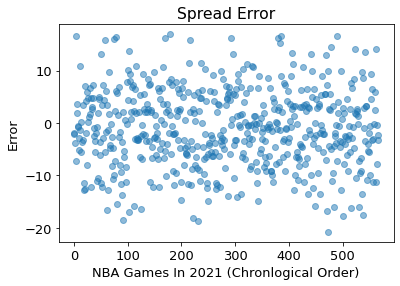

In [140]:
games_2021 = games[games["GAME_DATE_EST"].str.contains("2021")]
x = range(len(games_2021))
y1 = games_2021["spread"] - games_2021["pred_spread"]

plt.scatter(x, y1, alpha=0.5)
plt.title("Spread Error")
plt.xlabel("NBA Games In 2021 (Chronlogical Order)")
plt.ylabel("Error")

Text(0, 0.5, 'Probability')

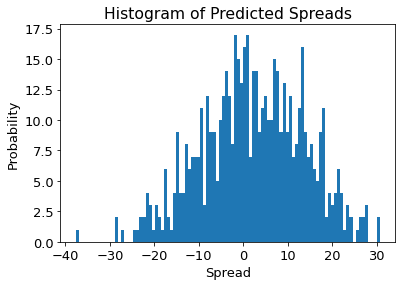

In [141]:
plt.hist(games_2021["pred_spread"], bins=100)
plt.title("Histogram of Predicted Spreads")
plt.xlabel("Spread")
plt.ylabel("Probability")
# The spread in the dataset has a maximum of 16

In [142]:


# Average and SD of the spread
avg_spread = np.mean(games["pred_spread"])
sd_spread = np.std(games["pred_spread"])
avg_spread, sd_spread

(2.940576805785484, 11.335944580648727)

Text(0, 0.5, 'Probability')

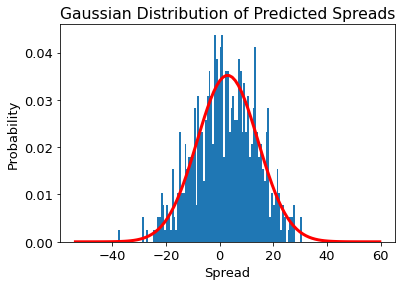

In [143]:
x = np.linspace(avg_spread - 5*sd_spread,  avg_spread + 5*sd_spread, 100)
plt.hist(games_2021["pred_spread"], bins=100, density=True)
plt.plot(x, stats.norm.pdf(x, avg_spread, sd_spread),
       'r', lw=3, label='norm pdf')
plt.title("Gaussian Distribution of Predicted Spreads")
plt.xlabel("Spread")
plt.ylabel("Probability")
# The predicted spread follows some gaussian distribution

In [144]:
# If spread is positive, HOME team is more likely to win and vice versa
def pred_winners(predictions):
    winners = []
    for i in predictions:
        if (i >= 0):
            winners.append(1)
        else:
            winners.append(0)
    return winners

home_wins = pred_winners(y_pred)

In [145]:
games["pred_HOME_TEAM_WINS"] = np.zeros(len(games["spread"]))
games["pred_HOME_TEAM_WINS"] = home_wins
games.head()

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2014-10-04  11400001            Final    1610612748       1610612740   
1    2014-10-05  11400002            Final    1610612761       1610612758   
2    2014-10-06  11400005            Final    1610612747       1610612743   
3    2014-10-06  11400004            Final    1610612741       1610612764   
4    2014-10-06  11400007            Final    1610612737       1610612740   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
0    2014    1610612748      86.0        0.431        0.679  ...   
1    2014    1610612761      99.0        0.440        0.771  ...   
2    2014    1610612747      98.0        0.448        0.682  ...   
3    2014    1610612741      81.0        0.338        0.719  ...   
4    2014    1610612737      93.0        0.419        0.821  ...   

   HOME_TEAM_WINS  home_team_abv  home_team_nick  vis_team_abv  vis_team_nick  \
0               0            MIA            Heat           NOP       Pelicans   
1               1            TOR         Raptors           SAC          Kings   
2               1            LAL          Lakers           DEN        Nuggets   
3               0            CHI           Bulls           WAS        Wizards   
4               1            ATL           Hawks           NOP       Pelicans   

   home_w_pct  vis_w_pct  spread  pred_spread  pred_HOME_TEAM_WINS  
0       0.659      0.573   -12.0    -4.295208                    0  
1       0.585      0.341     5.0    -5.864805                    0  
2       0.329      0.439     3.0    11.328199                    1  
3       0.585      0.537    -4.0    -4.554942                    0  
4       0.463      0.573     6.0    14.048883                    1  

[5 rows x 30 columns]

### Total Points Model

In [147]:
x_test

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
6999     2019-10-04  11900003            Final    1610612758       1610612754   
7000     2019-10-04  11900002            Final    1610612746       1610612745   
7001     2019-10-05  11900007            Final    1610612759       1610612753   
7002     2019-10-05  11900006            Final    1610612744       1610612747   
7003     2019-10-05  11900005            Final    1610612754       1610612758   
...             ...       ...              ...           ...              ...   
23466    2020-10-02  41900402            Final    1610612747       1610612748   
23467    2020-10-04  41900403            Final    1610612748       1610612747   
23468    2020-10-06  41900404            Final    1610612748       1610612747   
23469    2020-10-09  41900405            Final    1610612747       1610612748   
23470    2020-10-11  41900406            Final    1610612748       1610612747   

       SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
6999     2019    1610612758     131.0        0.494        0.778  ...   
7000     2019    1610612746      96.0        0.384        0.600  ...   
7001     2019    1610612759      89.0        0.388        0.750  ...   
7002     2019    1610612744     101.0        0.393        0.769  ...   
7003     2019    1610612754     130.0        0.521        0.944  ...   
...       ...           ...       ...          ...          ...  ...   
23466    2019    1610612747     124.0        0.505        0.588  ...   
23467    2019    1610612748     115.0        0.513        0.913  ...   
23468    2019    1610612748      96.0        0.427        0.808  ...   
23469    2019    1610612747     108.0        0.463        0.857  ...   
23470    2019    1610612748      93.0        0.443        0.591  ...   

       AST_away  REB_away  HOME_TEAM_WINS  home_team_abv  home_team_nick  \
6999       26.0      47.0               0            SAC           Kings   
7000       21.0      52.0               0            LAC        Clippers   
7001       29.0      47.0               0            SAS           Spurs   
7002       32.0      58.0               0            GSW        Warriors   
7003       24.0      35.0               1            IND          Pacers   
...         ...       ...             ...            ...             ...   
23466      29.0      37.0               1            LAL          Lakers   
23467      23.0      43.0               1            MIA            Heat   
23468      25.0      42.0               0            MIA            Heat   
23469      26.0      35.0               0            LAL          Lakers   
23470      23.0      46.0               0            MIA            Heat   

       vis_team_abv  vis_team_nick  home_w_pct  vis_w_pct  spread  
6999            IND         Pacers       0.341      0.683    -1.0  
7000            HOU        Rockets       0.695      0.659   -13.0  
7001            ORL          Magic       0.756      0.280   -36.0  
7002            LAL         Lakers       0.622      0.329   -22.0  
7003            SAC          Kings       0.683      0.341    24.0  
...             ...            ...         ...        ...     ...  
23466           MIA           Heat       0.329      0.659    10.0  
23467           LAL         Lakers       0.659      0.329    11.0  
23468           LAL         Lakers       0.659      0.329    -6.0  
23469           MIA           Heat       0.329      0.659    -3.0  
23470           LAL         Lakers       0.659      0.329   -13.0  

[1241 rows x 28 columns]

In [148]:
games['total_points'] = games['PTS_home'] + games['PTS_away']
x_test["total_points"] = x_test['PTS_home'] + x_test['PTS_away']
y_train_total = games["total_points"].astype('float')

y_test_total = x_test["total_points"].astype('float')
x_test_total = x_test[[ 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 
                 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']].astype('float')

<ipython-input-148-5b2e4dd1aac0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test["total_points"] = x_test['PTS_home'] + x_test['PTS_away']


In [149]:
y_train_total = y_train_total.fillna(0).values
y_test_total = y_test_total.fillna(0).values

In [107]:
regr = linear_model.LinearRegression()


regr.fit(x_train, y_train_total)
y_pred_total = regr.predict(x_train)

games["pred_total"] = np.zeros(len(games["spread"]))
games["pred_total"] = y_pred_total
games

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0        2014-10-04  11400001            Final    1610612748       1610612740   
1        2014-10-05  11400002            Final    1610612761       1610612758   
2        2014-10-06  11400005            Final    1610612747       1610612743   
3        2014-10-06  11400004            Final    1610612741       1610612764   
4        2014-10-06  11400007            Final    1610612737       1610612740   
...             ...       ...              ...           ...              ...   
24190    2021-03-21  22000647            Final    1610612751       1610612764   
24191    2021-03-21  22000167            Final    1610612738       1610612753   
24192    2021-03-21  22000646            Final    1610612743       1610612740   
24193    2021-03-21  22000016            Final    1610612745       1610612760   
24194    2021-03-21  22000645            Final    1610612748       1610612754   

       SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
0        2014    1610612748      86.0        0.431        0.679  ...   
1        2014    1610612761      99.0        0.440        0.771  ...   
2        2014    1610612747      98.0        0.448        0.682  ...   
3        2014    1610612741      81.0        0.338        0.719  ...   
4        2014    1610612737      93.0        0.419        0.821  ...   
...       ...           ...       ...          ...          ...  ...   
24190    2020    1610612751     113.0        0.489        0.727  ...   
24191    2020    1610612738     112.0        0.455        1.000  ...   
24192    2020    1610612743     108.0        0.500        0.800  ...   
24193    2020    1610612745     112.0        0.494        0.741  ...   
24194    2020    1610612748     106.0        0.402        0.826  ...   

       home_team_nick  vis_team_abv  vis_team_nick  home_w_pct  vis_w_pct  \
0                Heat           NOP       Pelicans       0.659      0.573   
1             Raptors           SAC          Kings       0.585      0.341   
2              Lakers           DEN        Nuggets       0.329      0.439   
3               Bulls           WAS        Wizards       0.585      0.537   
4               Hawks           NOP       Pelicans       0.463      0.573   
...               ...           ...            ...         ...        ...   
24190            Nets           WAS        Wizards       0.537      0.537   
24191         Celtics           ORL          Magic       0.305      0.280   
24192         Nuggets           NOP       Pelicans       0.439      0.573   
24193         Rockets           OKC        Thunder       0.659      0.720   
24194            Heat           IND         Pacers       0.659      0.683   

       spread  pred_spread  pred_HOME_TEAM_WINS  total_points  pred_total  
0       -12.0    -4.295208                    0         184.0  193.293663  
1         5.0    -5.864805                    0         193.0  191.751031  
2         3.0    11.328199                    1         193.0  197.478762  
3        -4.0    -4.554942                    0         166.0  170.721195  
4         6.0    14.048883                    1         180.0  187.424802  
...       ...          ...                  ...           ...         ...  
24190     7.0    -7.036391                    0         219.0  215.506626  
24191    16.0    16.448897                    1         208.0  199.037186  
24192    -5.0     2.779761                    1         221.0  218.453658  
24193    -2.0     0.304219                    1         226.0  210.708682  
24194    -3.0     0.279381                    1         215.0  203.640966  

[22954 rows x 32 columns]

In [108]:
regr_error = metrics.mean_squared_error(y_train_total, y_pred_total)
regr_error

174.17331185494214

Text(0, 0.5, 'Error')

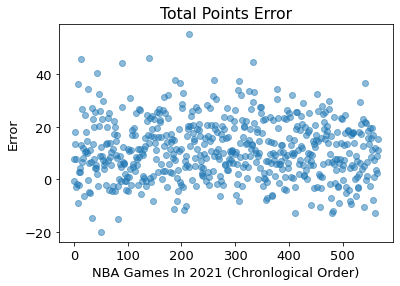

In [109]:
games_2021 = games[games["GAME_DATE_EST"].str.contains("2021")]
x = range(len(games_2021))
y1 = games_2021["total_points"] - games_2021["pred_total"]

plt.scatter(x, y1, alpha=0.5)
plt.title("Total Points Error")
plt.xlabel("NBA Games In 2021 (Chronlogical Order)")
plt.ylabel("Error")

Text(0, 0.5, 'Probability')

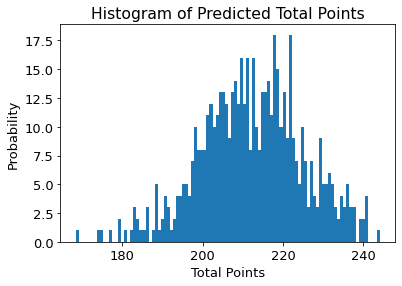

In [110]:
plt.hist(games_2021["pred_total"], bins=100)
plt.title("Histogram of Predicted Total Points")
plt.xlabel("Total Points")
plt.ylabel("Probability")


In [115]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [150]:
print('OSR2:', OSR2(regr, x_test_total, y_test_total, y_train_total))

OSR2: 0.6606064214441276


### Model Results

In [111]:
print ("Train Accuracy is", metrics.accuracy_score(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"]))
print ("Train Recall is", metrics.recall_score(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"]))

Train Accuracy is 0.8360634312102466
Train Recall is 0.8710578548849518


Text(0.5, 1.0, 'Confusion Matrix of Trained Data')

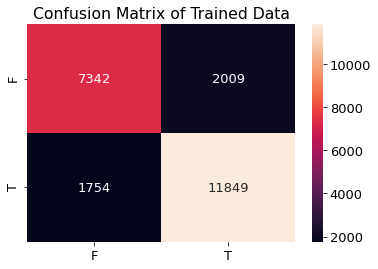

In [112]:
# Confusion Matrix
matrix = confusion_matrix(games["HOME_TEAM_WINS"], games["pred_HOME_TEAM_WINS"])
sns.heatmap(matrix,annot=True, fmt="d", yticklabels=["F", "T"], xticklabels=["F", "T"])
plt.title("Confusion Matrix of Trained Data")

In [113]:
# Cross validation scores
kf = KFold(4, shuffle=True, random_state=0)

cv_scores = cross_val_score(ridge_model,x_train,y_train,cv=kf)
print ("Cross-Validation Accuracies:", cv_scores)
print ("Overall CV score:", np.mean(cv_scores))

Cross-Validation Accuracies: [0.72940643 0.72155398 0.73577124 0.73616797]
Overall CV score: 0.7307249035417235


The mean of the random samples is 0.7307141225352738


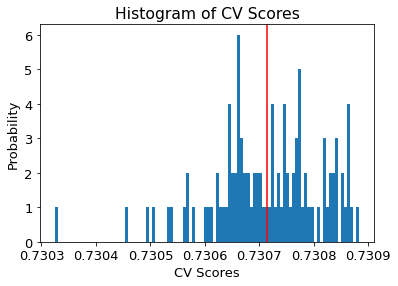

In [114]:
# Creating random samples of CV scores
k = 1000
scores = []

for i in range(100):
  kf = KFold(4, shuffle=True)
  cv_scores = cross_val_score(ridge_model,x_train,y_train,cv=kf)
  scores.append(np.mean(cv_scores))

mean = np.mean(scores)
plt.hist(scores, bins=100)
plt.axvline(mean, color='red')
plt.title("Histogram of CV Scores")
plt.xlabel("CV Scores")
plt.ylabel("Probability")
print("The mean of the random samples is", mean)

In [34]:
# Testing different alphas for ridge model to optimizing the best alpha
alphas = np.logspace(0, 3, 10)
scores_train = []
scores_cv = []

for i in alphas:
  kf = KFold(4, shuffle=True, random_state=0)
  model = Pipeline([('scaler', StandardScaler()), 
                      ('Ridge', Ridge(alpha=i, fit_intercept=True))])
  train_score = model.fit(x_train, y_train).score(x_train, y_train)
  cv_scores = cross_val_score(model,x_train,y_train,cv=kf)
  scores_cv.append(np.mean(cv_scores))
  scores_train.append(train_score)

<AxesSubplot:xlabel='alpha', ylabel='Score'>

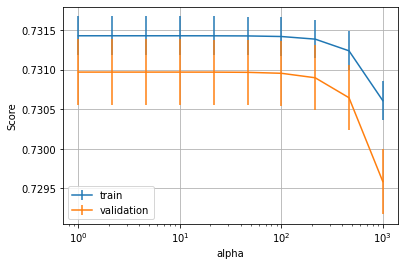

In [35]:
# Helper function from HW
def plot_cv_curve(hyperparm_grid,train_scores,val_scores):
  ax = plt.subplot(111)
  ax.errorbar(hyperparm_grid,train_scores,yerr=np.std(train_scores),label="train")
  ax.errorbar(hyperparm_grid,val_scores,yerr=np.std(val_scores),label="validation")
  ax.set_xlabel('alpha')
  ax.set_ylabel('Score')
  ax.set_xscale('log')
  ax.legend()
  ax.grid()
  return ax
plot_cv_curve(alphas, scores_train, scores_cv)

### Simulation

In [36]:
teams_avg_features = pd.DataFrame({"HOME_TEAM_ID": teams["TEAM_ID"], 
                                "ABBREVIATION":teams["ABBREVIATION"], 
                                "NICKNAME_home":teams["CITY"] +  " " + teams["NICKNAME"]})

home_features = ['FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home']

In [37]:
def initalize_teams():
    teams_avg_features["W_PCT_home"] = teams_avg_features.HOME_TEAM_ID.map(ranking.set_index('TEAM_ID')['W_PCT'].to_dict())

    for f in home_features:
      column = []
      for team in teams_avg_features["ABBREVIATION"]:
        avg = games[games["home_team_abv"] == team][f].mean()
        column.append(avg)
      name = f + "_avg"
      teams_avg_features[name] = np.zeros(len(teams_avg_features["ABBREVIATION"]))
      teams_avg_features[name] = column

initalize_teams()
# Get averages for each of the home features 
# These home features are the inital values for the simulation
teams_avg_features.head()

HOME_TEAM_ID ABBREVIATION         NICKNAME_home  W_PCT_home  \
0    1610612737          ATL         Atlanta Hawks       0.463   
1    1610612738          BOS        Boston Celtics       0.305   
2    1610612740          NOP  New Orleans Pelicans       0.573   
3    1610612741          CHI         Chicago Bulls       0.585   
4    1610612742          DAL      Dallas Mavericks       0.598   

   FG_PCT_home_avg  FT_PCT_home_avg  FG3_PCT_home_avg  AST_home_avg  \
0         0.458112         0.762230          0.349594     23.688050   
1         0.463425         0.772954          0.355294     23.529825   
2         0.459666         0.762986          0.353901     23.125974   
3         0.442985         0.760465          0.356615     22.969475   
4         0.463537         0.786488          0.363911     22.143207   

   REB_home_avg  
0     42.386164  
1     42.247953  
2     43.035065  
3     45.126984  
4     43.523868

In [38]:
# Information for each of the features for our ridge model
home_features_avg = ['FG_PCT_home_avg', 'FT_PCT_home_avg', 'FG3_PCT_home_avg', 'AST_home_avg', 'REB_home_avg']
for f in home_features_avg:
  print(f, teams_avg_features[f].describe())

FG_PCT_home_avg count    30.000000
mean      0.459939
std       0.008614
min       0.442985
25%       0.454033
50%       0.459715
75%       0.465031
max       0.479895
Name: FG_PCT_home_avg, dtype: float64
FT_PCT_home_avg count    30.000000
mean      0.758750
std       0.013519
min       0.734290
25%       0.750107
50%       0.758832
75%       0.766497
max       0.787419
Name: FT_PCT_home_avg, dtype: float64
FG3_PCT_home_avg count    30.000000
mean      0.355812
std       0.010576
min       0.341849
25%       0.348450
50%       0.355676
75%       0.359479
max       0.391134
Name: FG3_PCT_home_avg, dtype: float64
AST_home_avg count    30.000000
mean     22.595334
std       1.244525
min      20.260927
25%      21.784705
50%      22.489044
75%      23.443488
max      25.880689
Name: AST_home_avg, dtype: float64
REB_home_avg count    30.000000
mean     43.230377
std       0.793797
min      41.609896
25%      42.718726
50%      43.167875
75%      43.716877
max      45.126984
Name: REB_home_

In [39]:
# Returns a new dataframe containing n simulated games 
def start_simulation_from_avg_spreads(n, alpha, print_text=False, games=[] ,progress=True):
  game_simulation = pd.DataFrame({})
  sym = ["+", "-"]
  
  if (print_text):
    print('\033[1m' + "NBA Predictions" + '\033[0m')
  if len(games) >= 1:
    n = len(games)
  
  if progress:
    progress = widgets.FloatProgress(
      value=0,
      min=0,
      max=n,
      description='Processing:',
      bar_style='info',
      style={'bar_color': '#ff0000'},
      orientation='horizontal'
    )
    display(progress)
    time_start = timer()
  for i in range(n):
    progress.value = i + 1
    if len(games) >= 1:
      home_team = games[i][0]
      away_team = games[i][1]
    else:
      home_team = random.choice(team_abvs)
      away_team = home_team
      while (home_team == away_team):
         away_team = random.choice(team_abvs)
    home_team = teams_avg_features[teams_avg_features['ABBREVIATION'] == home_team].rename(columns={'ABBREVIATION':'home_team_abv'}).reset_index(drop=True)
    away_team = teams_avg_features[teams_avg_features['ABBREVIATION'] == away_team].rename(columns={'ABBREVIATION': 'vis_team_abv', 
                                                                                                    "W_PCT_home": "W_PCT_away",
                                                                                                    'NICKNAME_home': 'NICKNAME_away', 
                                                                                                    "FG_PCT_home_avg": "FG_PCT_away_avg",
                                                                                                    "FT_PCT_home_avg": "FT_PCT_away_avg",
                                                                                                    "FG3_PCT_home_avg":	"FG3_PCT_away_avg",
                                                                                                    "AST_home_avg": "AST_away_avg",
                                                                                                    "REB_home_avg":"REB_away_avg" }).reset_index(drop=True)

    game_teams = [home_team["NICKNAME_home"].item(),away_team["NICKNAME_away"].item()]


    game = pd.concat([home_team, away_team], axis=1, join="inner")

    features = ['FG_PCT_home_avg', 'FT_PCT_home_avg', 'FG3_PCT_home_avg', 'AST_home_avg', 'REB_home_avg', 
                 'FG_PCT_away_avg', 'FT_PCT_away_avg', 'FG3_PCT_away_avg', 'AST_away_avg', 'REB_away_avg']
    x_simulated = game[features].astype('float')

    # Predicing the spread and the winner
    spread = ridge_model.predict(x_simulated)
    
    game["spread"] = np.zeros(1)
    game["spread"] = spread
    
    home_wins = pred_winners(spread)
    game["HOME_TEAM_WINS"] = np.zeros(1)
    game["HOME_TEAM_WINS"] = home_wins

    # Updating features based on the winner
    
    home_perf_change = []
    away_perf_change = []
    for f in features:
      if "home" in f:
        # If home wins, the performance of the home team will increase and the performance for the away team will decrease.
        # alpha is the scalar value for each increase/decrease
          if sym[1 - game["HOME_TEAM_WINS"].item()] == "+":
            inc = np.round((alpha*np.std(teams_avg_features[f])), 6)
            dec = np.round(-(alpha*np.std(teams_avg_features[f])), 6)
            home_perf_change.append(inc)
            away_perf_change.append(dec)
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[0], f] += inc
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[1], f] += dec
          else:
            dec = np.round(-(alpha*np.std(teams_avg_features[f])), 6)
            inc = np.round((alpha*np.std(teams_avg_features[f])), 6)
            home_perf_change.append(dec)
            away_perf_change.append(inc)
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[0], f] += dec
            teams_avg_features.loc[teams_avg_features["NICKNAME_home"] == game_teams[1], f] += inc
    
    game["home_perf_change"] = np.zeros(1)
    game["home_perf_change"] = [home_perf_change]

    game["away_perf_change"] = np.zeros(1)
    game["away_perf_change"] = [away_perf_change]

    if (len(game_simulation) >= 1):
      game_simulation = game_simulation.append(game.iloc[0])
    else: 
      game_simulation = pd.concat([game_simulation, game], axis=1)


# Printing values for debugging
    if (print_text):
      print()
      print("Game", i+1, ":", game_teams[0], "vs", game_teams[1])

      print('\033[1m' + "Spread" + '\033[0m', ":", np.round(spread[0], 3))
      print(game_teams[1 - game["HOME_TEAM_WINS"].item()], "won the game.")

      print(game_teams[0], "Performance:", home_perf_change)
      print(game_teams[1], " Performance:", away_perf_change)


  game_simulation = game_simulation.reset_index(drop=True)
  if progress:
    time_end = timer()
    print("Elapsed Time: {0} second".format(time_end-time_start))
  progress.layout.display = 'none'
  return game_simulation

In [40]:
# Example simulation for debugging
start_simulation_from_avg_spreads(3,  0.05, print_text=True)

NBA Predictions


FloatProgress(value=0.0, bar_style='info', description='Processing:', max=3.0, style=ProgressStyle(bar_color='…


Game 1 : Indiana Pacers vs Sacramento Kings
Spread : 0.403
Indiana Pacers won the game.
Indiana Pacers Performance: [0.000423, 0.000665, 0.00052, 0.06118, 0.039023]
Sacramento Kings  Performance: [-0.000423, -0.000665, -0.00052, -0.06118, -0.039023]

Game 2 : Utah Jazz vs Minnesota Timberwolves
Spread : 2.072
Utah Jazz won the game.
Utah Jazz Performance: [0.000423, 0.000665, 0.00052, 0.061168, 0.039176]
Minnesota Timberwolves  Performance: [-0.000423, -0.000665, -0.00052, -0.061168, -0.039176]

Game 3 : San Antonio Spurs vs Golden State Warriors
Spread : 0.441
San Antonio Spurs won the game.
San Antonio Spurs Performance: [0.000424, 0.000664, 0.000521, 0.06115, 0.039191]
Golden State Warriors  Performance: [-0.000424, -0.000664, -0.000521, -0.06115, -0.039191]
Elapsed Time: 0.18705687200417742 second


HOME_TEAM_ID home_team_abv      NICKNAME_home  W_PCT_home  FG_PCT_home_avg  \
0    1610612754           IND     Indiana Pacers       0.683         0.452033   
1    1610612762           UTA          Utah Jazz       0.305         0.468717   
2    1610612759           SAS  San Antonio Spurs       0.756         0.479895   

   FT_PCT_home_avg  FG3_PCT_home_avg  AST_home_avg  REB_home_avg  \
0         0.766510          0.357299     21.514815     44.230864   
1         0.750299          0.359430     22.404092     43.272379   
2         0.759336          0.391134     23.758741     43.198135   

   HOME_TEAM_ID  ... W_PCT_away FG_PCT_away_avg  FT_PCT_away_avg  \
0    1610612758  ...      0.341        0.462489         0.763885   
1    1610612750  ...      0.488        0.453889         0.766457   
2    1610612744  ...      0.622        0.473891         0.766569   

   FG3_PCT_away_avg  AST_away_avg  REB_away_avg    spread  HOME_TEAM_WINS  \
0          0.359495     21.730013     42.423329  0.402999               1   
1          0.341849     22.669725     43.137615  2.071535               1   
2          0.374129     25.880689     43.986470  0.440713               1   

                                    home_perf_change  \
0   [0.000423, 0.000665, 0.00052, 0.06118, 0.039023]   
1  [0.000423, 0.000665, 0.00052, 0.061168, 0.039176]   
2  [0.000424, 0.000664, 0.000521, 0.06115, 0.039191]   

                                    away_perf_change  
0  [-0.000423, -0.000665, -0.00052, -0.06118, -0....  
1  [-0.000423, -0.000665, -0.00052, -0.061168, -0...  
2  [-0.000424, -0.000664, -0.000521, -0.06115, -0...  

[3 rows x 22 columns]

# Helper Functions

In [41]:
def create_tabs(df):
  teams_ = df["NICKNAME_home"].unique()
  tabs = []
  
  for t in teams_:
    text = []
    tab_widget = []
    team = df[df["NICKNAME_home"] == t]
    features = ['FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB']

    info_accordion_text = "<b>ℹ Each tab contains all games where " + team.iloc[0]["NICKNAME_home"] + " is the home team." + "<br>" + \
    "ℹ FG_PCT = Field Goal Percentage | FT_PCT = Free Throw Percentage | FG3_PCT = Field Goal (3 Points) Percentage | AST = Assist | REB = Rebounds</b>"
    tab_widget.append(widgets.HTML(value=info_accordion_text,disabled=False))

    for i in range(len(team)):
      team_text = "Home: " + team.iloc[i]["NICKNAME_home"] + " | " + "Away: " + team.iloc[i]["NICKNAME_away"] + "<br>" + \
      "<b>Points:</b> " + " | "  + "<br>" + \
      "Projected Winner: " + [team.iloc[i]["NICKNAME_away"], team.iloc[i]["NICKNAME_home"]][team.iloc[i]["HOME_TEAM_WINS"]] + "<br>" + \
      "Spread: " + str(team.iloc[i]["spread"]) + "<br>" + \
      "<u>" + team.iloc[i]["NICKNAME_home"] + "</u>" + "</u><br>" + \
      " ".join([features[i-1]  + ": " + ("+" + str(value)).replace("+-", "-") + " |" for i, value in enumerate(team.iloc[i]["home_perf_change"])]) + "<br>" + \
      "<u>" + team.iloc[i]["NICKNAME_away"] + "</u>" + "</u><br>" + \
      " ".join([features[i-1]  + ": " + ("+" + str(value)).replace("+-", "-") + " |" for i, value in enumerate(team.iloc[i]["away_perf_change"])])

      text_widget = widgets.HTML(value=team_text,disabled=False)
      widget = widgets.Accordion(children=[text_widget], selected_index=None)
      widget.set_title(0, "Game " + str(i+1))
      tab_widget.append(widget)
    tabs.append(tab_widget)

  return tabs

def click(button):
    value = button.owner.value
    if value == "1 NBA Game":
      select_home.layout.display = "block"
      select_away.layout.display = "block"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Selects 2 teams to set as the home team and away team" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns 1 simulated game</b>"
    elif value == "Random Simulation":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "block"
      description.value = "<b>ℹ Runs a random simuation where for each game, two random teams are choosen to play agaisnt each other." + "<br>" + \
"# of Games: The number of NBA games to simulate. Default: 10" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns n simulated games</b>"
    elif value == "2018-19 Season":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Simulates games from the 2018-2019 season schedule in the NBA dataset" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns simulated games from the 2018-19 season (takes a while to process).</b>"
    elif value == "2020-21 Season (May)":
      select_home.layout.display = "none"
      select_away.layout.display = "none"
      n_slider.layout.display = "none"
      description.value = "<b>ℹ Simulates games from the May 2021 NBA season schedule" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns simulated games from the 2018-19 season.</b>"

def clear_results(button):
    clear_output()
    display(title,select,widgets.HBox([select_home, select_away]),n_slider,alpha_float, widgets.HBox([start, clear_button]))

# Datasets

In [42]:
# 2018-19 Schedule from NBA dataset
teams_1819 = []
games_1819 = games[(games['GAME_DATE_EST'] >= '2018-10-16') & (games['GAME_DATE_EST'] <= '2019-06-30')]
home_teams = (games_1819["home_team_abv"]).values
vis_teams = (games_1819["vis_team_abv"]).values
for i in range(len(home_teams)):
  teams_1819.append([home_teams[i], vis_teams[i]])
teams_1819[:5]
# Aggreating the data into the right form for the simulation

[['GSW', 'OKC'],
 ['BOS', 'PHI'],
 ['PHX', 'DAL'],
 ['LAC', 'DEN'],
 ['SAC', 'UTA']]

In [43]:
# May 2021 Schedule from NBA 
# Source: https://www.basketball-reference.com/leagues/NBA_2021_games-may.html

games_21 = pd.read_csv('nba_games_may2021.csv')
games_21["home_team_abv"] = games_21["Home/Neutral"].map(teams_avg_features.set_index('NICKNAME_home')['ABBREVIATION'].to_dict())
games_21["vis_team_abv"] = games_21["Visitor/Neutral"].map(teams_avg_features.set_index('NICKNAME_home')['ABBREVIATION'].to_dict())

teams_21 = []
home_teams_21 = (games_21["home_team_abv"]).values
vis_teams_21 = (games_21["vis_team_abv"]).values
for i in range(len(home_teams_21)):
  teams_21.append([home_teams_21[i], vis_teams_21[i]])
teams_21[:5]
# Aggreating the data into the right form for the simulation

[['CHA', 'DET'],
 ['HOU', 'GSW'],
 ['ATL', 'CHI'],
 ['CLE', 'MIA'],
 ['MIN', 'NOP']]

# **UI**

In [44]:
title_text = "<big>" + "NBA Spread & Winner Predictor" + "</big>"
title = widgets.HTML(value=title_text,disabled=False)

description_text = "<b>ℹ Selects 2 teams to set as the home team and away team" + "<br>" + \
"Alpha: The scalar value of the rewards for each team based on the outcome of the model. Ex. If home wins, their performance increases are multiplied by alpha and vice versa. Default: 0.05" + "<br>" + \
"Returns 1 simulated game</b>"
description = widgets.HTML(value=description_text,disabled=False)

select_home = widgets.Select(
    options=teams_avg_features["NICKNAME_home"].values,
    value=teams_avg_features["NICKNAME_home"].values[0],
    description='Home Team:',
    disabled=False
)
select_away = widgets.Select(
    options=teams_avg_features["NICKNAME_home"].values,
    value=teams_avg_features["NICKNAME_home"].values[0],
    description='Away Team:',
    disabled=False
)
n_slider = widgets.BoundedIntText(
    value=10,
    min=1,
    max=1000,
    step=1,
    description='# of Games:',
    disabled=False
)
n_slider.layout.display = "none"

alpha_float = widgets.BoundedFloatText(
    value=0.05,
    min=0,
    max=2,
    step=0.01,
    description="Alpha:",
    disabled=False
)

select = widgets.ToggleButtons(
    options=['1 NBA Game', 'Random Simulation', "2018-19 Season", "2020-21 Season (May)"],
    description='Options:',
    disabled=False,
    button_style='', 
    tooltip='Description',
)

start = widgets.Button(
    value=False,
    description='Start Simulation',
    disabled=False,
    button_style='',
    tooltip='Description',
    icon='check'
)

clear_button = widgets.Button(
    value=False,
    description='Clear Results',
    disabled=False,
    button_style='', 
    tooltip='Clear the results of all tabs',
    icon='check'
)
clear_button.on_click(clear_results)

tab = widgets.Tab(children=[])
tab.layout.display = 'none'

def start_sim(button):
    value = select.value
    if value == "1 NBA Game":
      alpha = alpha_float.value
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = [[team_1, team_2]]

      n = len(teams_select)
      df = start_simulation_from_avg_spreads(0, alpha, print_text=False, games=teams_select)
    elif value == "Random Simulation":
      n = n_slider.value
      alpha = alpha_float.value

      initalize_teams()
      df = start_simulation_from_avg_spreads(n,  alpha, print_text=False, games=[])
    elif value == "2018-19 Season":
      alpha = alpha_float.value
      
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = teams_1819

      n = len(teams_select)
      df = start_simulation_from_avg_spreads(0,  alpha, print_text=False, games=teams_select)

    elif value == "2020-21 Season (May)":
      alpha = alpha_float.value
     
      
      initalize_teams()
      team_1 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_home.value]["ABBREVIATION"].values[0]
      team_2 = teams_avg_features[teams_avg_features["NICKNAME_home"] == select_away.value]["ABBREVIATION"].values[0]
      teams_select = teams_21

      n = len(teams_select)
      df = start_simulation_from_avg_spreads(0,  alpha, print_text=False, games=teams_select)

    children = []
    games_tabs = create_tabs(df)
    
    %matplotlib inline
    df_plot = df.groupby(['NICKNAME_home']).mean()

    def f():
        plt.figure(figsize=[13,7])
        x = df_plot.index.values
        y = df_plot["HOME_TEAM_WINS"].values
        plt.barh(x, y, height=0.5)
        
        plt.rcParams['font.size'] = '13'
        plt.title("Winning Percentage of Home Teams")
        plt.xlabel("Winning Percentage")
        plt.tight_layout()
        plt.show()

    interactive_plot = interactive(f)
    output = interactive_plot.children[-1]
    output.layout.height = '500px'
    def setup_ui(df):

      out = widgets.Output()
      with out:
          display(df)
      return out

    df_wp = df_plot[["HOME_TEAM_WINS", "spread"]].rename(columns={"HOME_TEAM_WINS": "Avg WP", "spread": " Avg Spread"}).sort_values("Avg WP", ascending=False)
    df_wp.index.name = 'Home Teams'
    widget = setup_ui(df_wp)

    children.append(widgets.HBox([widget, interactive_plot]))
    for i in range(len(games_tabs)):
        children.append(widgets.VBox(games_tabs[i]))
  
    tab = widgets.Tab(children=children)
    li = enumerate(np.insert(df["home_team_abv"].unique(), 0, "Summary"))
    [tab.set_title(i, name) for i, name in li]
    display(tab)

start.on_click(start_sim)
select.observe(click)

display(title,
        select,
        description,
        widgets.HBox([select_home, select_away]),
        n_slider,
        alpha_float, 
        widgets.HBox([start, clear_button]),)

HTML(value='<big>NBA Spread & Winner Predictor</big>')

ToggleButtons(description='Options:', options=('1 NBA Game', 'Random Simulation', '2018-19 Season', '2020-21 S…

HTML(value='<b>ℹ Selects 2 teams to set as the home team and away team<br>Alpha: The scalar value of the rewar…

BoundedIntText(value=10, description='# of Games:', layout=Layout(display='none'), max=1000, min=1)

BoundedFloatText(value=0.05, description='Alpha:', max=2.0, step=0.01)

FloatProgress(value=0.0, bar_style='info', description='Processing:', max=1.0, style=ProgressStyle(bar_color='…

Elapsed Time: 0.047827041998971254 second


FloatProgress(value=0.0, bar_style='info', description='Processing:', max=1.0, style=ProgressStyle(bar_color='…

Elapsed Time: 0.0811623879999388 second


FloatProgress(value=0.0, bar_style='info', description='Processing:', max=1.0, style=ProgressStyle(bar_color='…

Elapsed Time: 0.04671711000264622 second


FloatProgress(value=0.0, bar_style='info', description='Processing:', max=135.0, style=ProgressStyle(bar_color…

Elapsed Time: 7.2503312320041005 second
